In [1]:
from itertools import product

import graspy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from graspy.embed import select_dimension, AdjacencySpectralEmbed
from graspy.inference.latent_distribution_test import _median_sign_flips, _fit_plug_in_variance_estimator
from graspy.inference import LatentDistributionTest
from graspy.simulations import rdpg

from hyppo.ksample import KSample
from hyppo._utils import gaussian

from joblib import Parallel, delayed

from scipy.stats import multivariate_normal
from tqdm import tqdm

import sys
sys.path.append("./")
from seedless_procrustes import *
from utils import load_data

%matplotlib inline

print(graspy.__version__)

0.3.0


<AxesSubplot:title={'center':'Right'}>

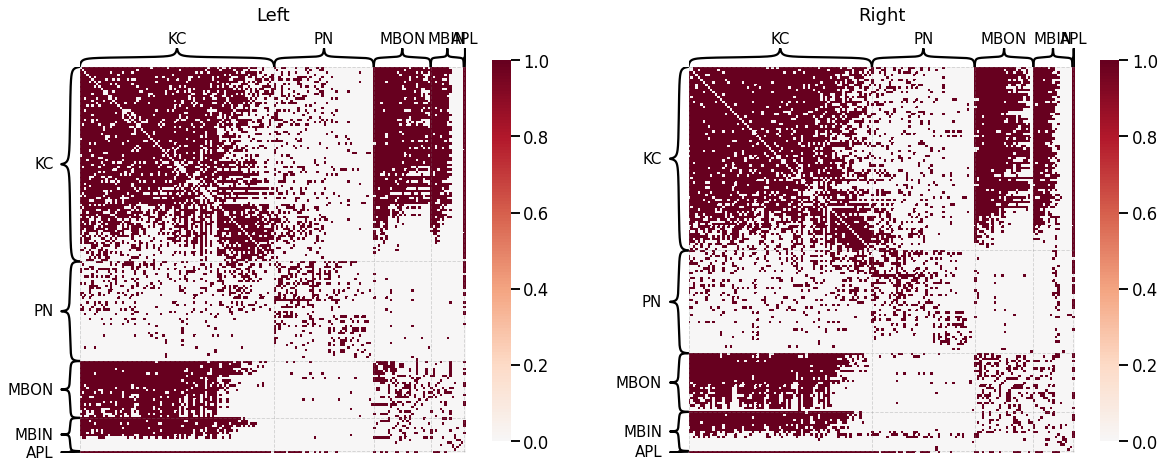

In [2]:
A_l, nodes_l, A_r, nodes_r, hemispheres = load_data()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
graspy.plot.heatmap(A_l, inner_hier_labels=nodes_l, hier_label_fontsize=15, sort_nodes=True, ax=ax[0], title="Left")
graspy.plot.heatmap(A_r, inner_hier_labels=nodes_r, hier_label_fontsize=15, sort_nodes=True, ax=ax[1], title="Right")

In [32]:
def hypothesis_test(X1, X2, flip):
    tests = [KSample('Dcorr'), KSample('MGC'), KSample('HSic', compute_distance=gaussian)]
    
    if flip == 'median':
        X1_flipped, X2_flipped = _median_sign_flips(X1, X2)
        
    elif flip == 'seedless':
        Q = SeedlessProcrustes().fit_predict(X1, X2)
        X1_flipped = X1 @ Q
        X2_flipped = X2
        
    
    pvals = []
    for test in tests:
        res = test.test(X1_flipped, X2_flipped, auto=False)
        pvals.append(res[1])
        
    return pvals

def embed_graphs(A1, A2):
    num_dims1 = select_dimension(A1)[0][-1]
    num_dims2 = select_dimension(A2)[0][-1]
    n_components = max(num_dims1, num_dims2)
    
    ase = AdjacencySpectralEmbed(n_components=n_components, diag_aug=True, check_lcc=False)
    X1_hat = ase.fit_transform(A1)
    X2_hat = ase.fit_transform(A2)
    
    return X1_hat, X2_hat

def run_non_replacement(X1_hat, X2_hat, n_verts_to_perterb, delta, n_sims=96):
    """
    delta is non-negative number
    """
    d = X1_hat.shape[1]
    N = X1_hat.shape[0]
    M = X2_hat.shape[0]
    
    X1_cov = _fit_plug_in_variance_estimator(X1_hat)(X1_hat) / N
    X2_cov = _fit_plug_in_variance_estimator(X2_hat)(X2_hat) / M
    
    def worker():    
        # Sample new latents
        X1_new = []
        verts_to_perterb = np.random.choice(range(N), size=n_verts_to_perterb, replace=False)
        
        for idx in range(N):
            if idx in verts_to_perterb:
                direction = multivariate_normal.rvs(cov=np.eye(d), random_state=np.random.randint(2147483647))
                direction /= np.linalg.norm(direction)
                shift = direction * delta
                
                mean = X1_hat[idx] + shift
            else:
                mean = X1_hat[idx]

            X1_new.append(
                multivariate_normal.rvs(
                    mean,
                    X1_cov[idx], 
                    random_state=np.random.randint(2147483647)
                )
            )
        X1_new = np.array(X1_new)
        X2_new = np.array(
            [
                multivariate_normal.rvs(
                    X2_hat[idx], 
                    X2_cov[idx], 
                    random_state=np.random.randint(2147483647)
                ) for idx in range(M)
            ]
        )
        
        # Sample new graphs
        A1 = rdpg(X1_new, rescale=False)
        A2 = rdpg(X2_new, rescale=False)
        X1_resampled, X2_resampled = embed_graphs(A1, A2)
        
        # Compute pvals
        pvals_median = hypothesis_test(X1_resampled, X2_resampled, "median")
        pvals_seedless = hypothesis_test(X1_resampled, X2_resampled, "seedless")
        
        return np.hstack([pvals_median, pvals_seedless])
    
    res = Parallel(-1, verbose=0)(delayed(worker)() for _ in range(n_sims))
    
    res = np.array(res)
    power = (res <= 0.05).mean(axis=0)
    
    return [n_verts_to_perterb, delta, *power]

def run_replacement(X1_hat, X2_hat, X1_verts, X2_verts, n_verts_to_perterb, delta, n_sims=96):
    """
    delta is non-negative number
    """
    d = X1_hat.shape[1]
    N = X1_hat.shape[0]
    M = X2_hat.shape[0]
    
    X1_cov = _fit_plug_in_variance_estimator(X1_hat)(X1_hat) / N
    X2_cov = _fit_plug_in_variance_estimator(X2_hat)(X2_hat) / M
    
    def worker():    
        # Sample new latents
        X1_new = []
        verts_to_perterb = np.random.choice(range(X1_verts), size=n_verts_to_perterb, replace=False)
        
        X1_idx = np.random.choice(range(N), size=X1_verts, replace=True)
        X2_idx = np.random.choice(range(M), size=X2_verts, replace=True)
        
        X1_hat_replaced = X1_hat[X1_idx]
        X2_hat_replaced = X2_hat[X2_idx]
        
        X1_cov_replaced = X1_cov[X1_idx]
        X2_cov_replaced = X2_cov[X2_idx]
        
        for idx in range(X1_verts):
            if idx in verts_to_perterb:
                direction = multivariate_normal.rvs(cov=np.eye(d), random_state=np.random.randint(2147483647))
                direction /= np.linalg.norm(direction)
                shift = direction * delta
                
                mean = X1_hat_replaced[idx] + shift
            else:
                mean = X1_hat_replaced[idx]

            X1_new.append(
                multivariate_normal.rvs(
                    mean,
                    X1_cov_replaced[idx], 
                    random_state=np.random.randint(2147483647)
                )
            )
        X1_new = np.array(X1_new)
        X2_new = np.array(
            [
                multivariate_normal.rvs(
                    X2_hat_replaced[idx], 
                    X2_cov_replaced[idx], 
                    random_state=np.random.randint(2147483647)
                ) for idx in range(X2_verts)
            ]
        )
        
        # Sample new graphs
        A1 = rdpg(X1_new, rescale=False)
        A2 = rdpg(X2_new, rescale=False)
        X1_resampled, X2_resampled = embed_graphs(A1, A2)
        
        # Compute pvals
        pvals_median = hypothesis_test(X1_resampled, X2_resampled, "median")
        pvals_seedless = hypothesis_test(X1_resampled, X2_resampled, "seedless")
        
        return np.hstack([pvals_median, pvals_seedless])
    
    res = Parallel(-1, verbose=0)(delayed(worker)() for _ in range(n_sims))
    
    res = np.array(res)
    power = (res <= 0.05).mean(axis=0)
    
    return [X1_verts, X2_verts, n_verts_to_perterb, delta, *power]

In [4]:
X1_hat, X2_hat = embed_graphs(A_l, A_r)

print(X1_hat.shape[-1])

3


In [9]:
n_verts_to_perterbs = np.linspace(0, 100, 6, dtype=int)
deltas = np.linspace(0, 1, 6)

args = [
    dict(n_verts_to_perterb=n_verts_to_perterb, delta=delta) 
    for n_verts_to_perterb, delta 
    in product(n_verts_to_perterbs, deltas)
]

In [12]:
res = []

for arg in tqdm(args):
    tmp = run_non_replacement(X1_hat, X2_hat, **arg)
    res.append(tmp)

100%|██████████| 36/36 [4:57:58<00:00, 496.64s/it]  


In [17]:
cols = ["n_verts_perterbed", "delta", "dcorr_median", "mgc_median", "hsic_median", "dcorr_seedless", "mgc_seedless", "hsic_seedless"]

df = pd.DataFrame(res, columns=cols)

df.to_csv("./no_component_replacement.csv", index=False)

In [33]:
res = []

for arg in tqdm(args):
    tmp = run_replacement(X1_hat, X2_hat, X1_verts=150, X2_verts=150, **arg)
    res.append(tmp)

100%|██████████| 36/36 [3:58:09<00:00, 396.92s/it]  


In [34]:
res

[[150,
  150,
  0,
  0.0,
  0.5208333333333334,
  0.6770833333333334,
  0.23958333333333334,
  0.010416666666666666,
  0.16666666666666666,
  0.0],
 [150,
  150,
  0,
  0.2,
  0.5416666666666666,
  0.6979166666666666,
  0.2604166666666667,
  0.03125,
  0.20833333333333334,
  0.020833333333333332],
 [150,
  150,
  0,
  0.4,
  0.59375,
  0.8020833333333334,
  0.3229166666666667,
  0.010416666666666666,
  0.1875,
  0.010416666666666666],
 [150,
  150,
  0,
  0.6000000000000001,
  0.6041666666666666,
  0.7916666666666666,
  0.3541666666666667,
  0.010416666666666666,
  0.15625,
  0.0],
 [150,
  150,
  0,
  0.8,
  0.5520833333333334,
  0.6979166666666666,
  0.3229166666666667,
  0.010416666666666666,
  0.22916666666666666,
  0.010416666666666666],
 [150,
  150,
  0,
  1.0,
  0.4791666666666667,
  0.6770833333333334,
  0.2916666666666667,
  0.010416666666666666,
  0.1875,
  0.010416666666666666],
 [150,
  150,
  20,
  0.0,
  0.5833333333333334,
  0.8125,
  0.22916666666666666,
  0.03125,
  0

In [35]:
cols = ["x1_verts", "x2_verts", "n_verts_perterbed", "delta", "dcorr_median", "mgc_median", "hsic_median", "dcorr_seedless", "mgc_seedless", "hsic_seedless"]
df2 = pd.DataFrame(res, columns=cols)
df2.to_csv("./component_replacement.csv", index=False)

In [36]:
df2

,x1_verts,x2_verts,n_verts_perterbed,delta,dcorr_median,mgc_median,hsic_median,dcorr_seedless,mgc_seedless,hsic_seedless
0,150,150,0,0.0,0.520833,0.677083,0.239583,0.010417,0.166667,0.000000
1,150,150,0,0.2,0.541667,0.697917,0.260417,0.031250,0.208333,0.020833
2,150,150,0,0.4,0.593750,0.802083,0.322917,0.010417,0.187500,0.010417
3,150,150,0,0.6,0.604167,0.791667,0.354167,0.010417,0.156250,0.000000
4,150,150,0,0.8,0.552083,0.697917,0.322917,0.010417,0.229167,0.010417
5,150,150,0,1.0,0.479167,0.677083,0.291667,0.010417,0.187500,0.010417
6,150,150,20,0.0,0.583333,0.812500,0.229167,0.031250,0.145833,0.020833
7,150,150,20,0.2,0.614583,0.791667,0.302083,0.020833,0.166667,0.010417
8,150,150,20,0.4,0.625000,0.739583,0.385417,0.000000,0.093750,0.000000
9,150,150,20,0.6,0.552083,0.781250,0.281250,0.010417,0.218750,0.000000


<AxesSubplot:>

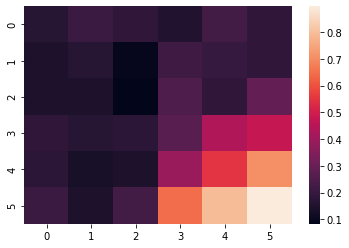

In [38]:
sns.heatmap(df2.mgc_seedless.values.reshape(6, 6))